## Importaciones

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Carga y Preprocesamiento de datos

In [31]:
train_dir = 'train_small'
test_dir = 'test_small'

In [32]:
img_size = 224
batch_size = 64
lr = 1e-4

In [34]:
def normalization(img):
    img = img / 255.0  # Convierte a [0,1]
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalización ImageNet
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=normalization,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=normalization
)

In [35]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.dirname(test_dir),
    classes=[os.path.basename(test_dir)],
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2500 images belonging to 1 classes.


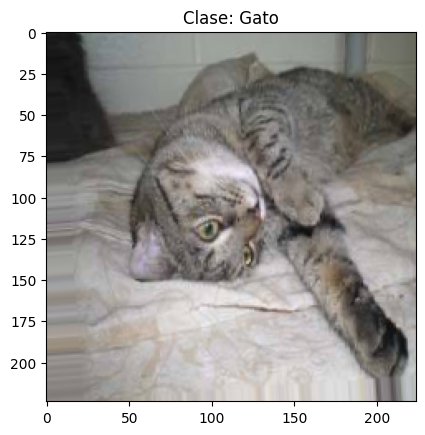

In [ ]:
def inverse_normalize(img):
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    return img

# Ejemplo de visualización:
x, y = next(train_generator)
plt.imshow(inverse_normalize(x[0]))
plt.title(f"Clase: {'Perro' if y[0] else 'Gato'}")
plt.show()

## Construcción del modelo

In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [40]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compilación con optimizador mejorado
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entrenamiento y visualización de métricas.

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

In [16]:
# Fase 1: Entrenar solo las nuevas capas
print("\n--- FASE 1: Entrenamiento de capas nuevas ---")
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


--- FASE 1: Entrenamiento de capas nuevas ---


/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


2025-06-20 02:25:08.787756: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2025-06-20 02:25:08.945066: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38880000 exceeds 10% of free system memory.
2025-06-20 02:25:08.972249: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-20 02:25:09.203127: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-20 02:25:09.288393: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4976 - loss: 0.7042 - precision: 0.4767 - recall: 0.4833

63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.4979 - loss: 0.7041 - precision: 0.4774 - recall: 0.4837 - val_accuracy: 0.5890 - val_loss: 0.6812 - val_precision: 0.6083 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.5807 - loss: 0.6779 - precision: 0.5841 - recall: 0.5186 - val_accuracy: 0.5840 - val_loss: 0.6756 - val_precision: 0.6654 - val_recall: 0.3380 - learning_rate: 1.0000e-04
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5835 - loss: 0.6752 - precision: 0.6131 - recall: 0.4387

63/63 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.5836 - loss: 0.6752 - precision: 0.6129 - recall: 0.4401 - val_accuracy: 0.5930 - val_loss: 0.6688 - val_precision: 0.5756 - val_recall: 0.7080 - learning_rate: 1.0000e-04
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5853 - loss: 0.6708 - precision: 0.5855 - recall: 0.5512

63/63 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.5854 - loss: 0.6707 - precision: 0.5857 - recall: 0.5511 - val_accuracy: 0.5980 - val_loss: 0.6650 - val_precision: 0.5891 - val_recall: 0.6480 - learning_rate: 1.0000e-04
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6025 - loss: 0.6635 - precision: 0.6061 - recall: 0.5940

63/63 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.6026 - loss: 0.6634 - precision: 0.6062 - recall: 0.5939 - val_accuracy: 0.6020 - val_loss: 0.6652 - val_precision: 0.7318 - val_recall: 0.3220 - learning_rate: 1.0000e-04
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6076 - loss: 0.6596 - precision: 0.6397 - recall: 0.4898

63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.6077 - loss: 0.6595 - precision: 0.6395 - recall: 0.4908 - val_accuracy: 0.6220 - val_loss: 0.6565 - val_precision: 0.6649 - val_recall: 0.4920 - learning_rate: 1.0000e-04
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6288 - loss: 0.6516 - precision: 0.6384 - recall: 0.6072

63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.6287 - loss: 0.6516 - precision: 0.6383 - recall: 0.6067 - val_accuracy: 0.6310 - val_loss: 0.6520 - val_precision: 0.6785 - val_recall: 0.4980 - learning_rate: 1.0000e-04
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.6243 - loss: 0.6457 - precision: 0.6279 - recall: 0.5686 - val_accuracy: 0.6260 - val_loss: 0.6503 - val_precision: 0.6853 - val_recall: 0.4660 - learning_rate: 1.0000e-04
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.6111 - loss: 0.6571 - precision: 0.6228 - recall: 0.5695 - val_accuracy: 0.6200 - val_loss: 0.6517 - val_precision: 0.6087 - val_recall: 0.6720 - learning_rate: 1.0000e-04
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.6296 - loss: 0.6490 - precision: 0.6320 - recall: 0.5880 - val_accuracy: 0.6290 - val_loss: 0.6475 - val_precision: 0.6729 - val_recall: 0.5020 - learning_rate: 1.0000e-04
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6313 - loss: 0.6450 - precision: 0.6364 - recall: 0.6238 - val_accuracy: 0.6350 - val_loss: 0.6464 - val_precision: 0.7039 - val_recall: 0.4660 - learning_rate: 1.0000e-04
Epoch 13/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.6175 - loss: 0.6486 - precision: 0.6336 - recall: 0.5693 - val_accuracy: 0.6290 - val_loss: 0.6444 - val_precision: 0.7172 - val_recall: 0.4260 - learning_rate: 1.0000e-04
Epoch 14/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6098 - loss: 0.6495 - precision: 0.6352 - recall: 0.5147 - val_accuracy: 0.6210 - val_loss: 0.6455 - val_precision: 0.6098 - val_recall: 0.6720 - learning_rate: 1.0000e-04
Epoch 15/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6542 - loss: 0.6314 - precision: 0.6666 - recall: 0.6544

63/63 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.6539 - loss: 0.6316 - precision: 0.6663 - recall: 0.6536 - val_accuracy: 0.6380 - val_loss: 0.6412 - val_precision: 0.6885 - val_recall: 0.5040 - learning_rate: 1.0000e-04


In [ ]:
print("\n--- FASE 2: Fine-tuning ---")
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=lr/10),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]  # Métricas añadidas
)

history_fine = model.fit(
    train_generator,
    epochs=10,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


--- FASE 2: Fine-tuning ---


In [18]:
val_loss, val_acc, val_prec, val_rec = model.evaluate(val_generator)
print(f"\nRendimiento final en validación:")
print(f"Accuracy: {val_acc:.2%}")
print(f"Precisión: {val_prec:.2%}")
print(f"Recall: {val_rec:.2%}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7339 - loss: 0.6096 - precision_1: 0.3034 - recall_1: 0.2907

Rendimiento final en validación:
Accuracy: 64.50%
Precisión: 70.54%
Recall: 49.80%


In [44]:
predicciones = model.predict(test_generator, verbose=1)
clases_predichas = (predicciones > 0.5).astype(int).flatten()

  19/2500 ━━━━━━━━━━━━━━━━━━━━ 1:45 42ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step


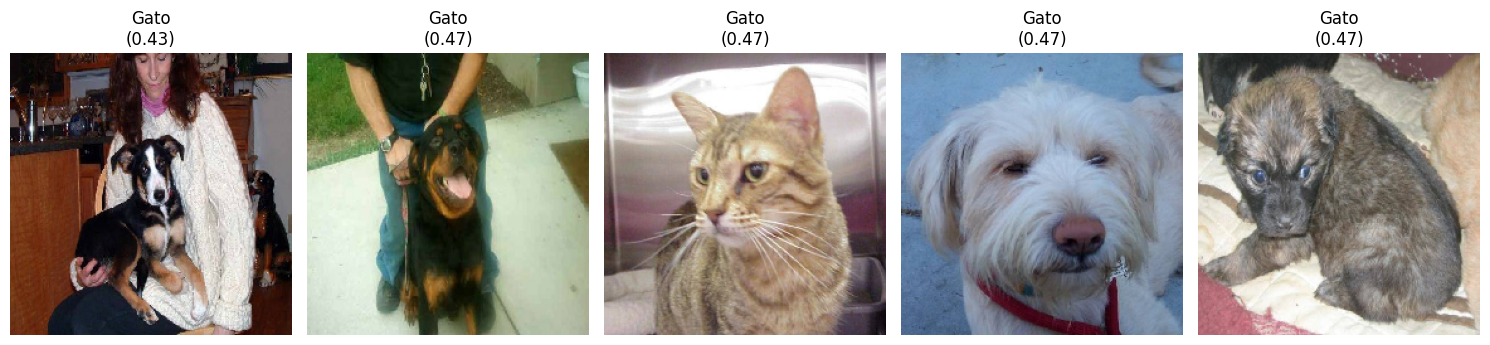

In [56]:
# Visualización de resultados
nombres_archivos = test_generator.filenames
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(len(nombres_archivos))
    ruta_img = os.path.join(test_dir, nombres_archivos[idx].replace('test_small/', ''))    
    img = tf.keras.preprocessing.image.load_img(ruta_img, target_size=(img_size, img_size))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    etiqueta = "Perro" if clases_predichas[idx] == 1 else "Gato"
    plt.title(f"{etiqueta}\n({predicciones[idx][0]:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [58]:
print(predicciones[:5])

[[0.47026917]
 [0.4499767 ]
 [0.42880878]
 [0.4659061 ]
 [0.46376783]]


In [22]:
from pickle import dump
with open('models/modelo_version2.pkl', 'wb') as file:
    dump(model, file)